In [1]:
import cv2
import numpy as np
import scipy
from scipy.spatial import distance
#from scipy.misc import imread
import _pickle as cPickle
#import cPickle as pickle
import pickle
import random
import os
import matplotlib.pyplot as plt
import skimage, imageio

In [2]:
# Feature extractor
def extract_features(image_path, vector_size=32):
    image = imageio.imread(image_path)
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print ('Error: ', e)
        return None

    return dsc


def batch_extractor(images_path, pickled_db_path="features.pck"):
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]

    result = {}
    for f in files:
        print ('Extracting features from image %s' % f)
        name = f.split('/')[-1].lower()
        result[name] = extract_features(f)
    
    # saving all our feature vectors in pickled file
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(result, fp)

In [3]:
class Matcher(object):

    def __init__(self, pickled_db_path="features.pck"):
        with open(pickled_db_path, 'rb') as fp:
            self.data = pickle.load(fp)
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        img_distances = self.cos_cdist(features)
        print("Image Distance", img_distances)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()

FILES: ['C:\\Users\\Prakalp.Somawanshi\\Local Store\\QRM\\Projects\\ImgCmp\\data\\img1.png', 'C:\\Users\\Prakalp.Somawanshi\\Local Store\\QRM\\Projects\\ImgCmp\\data\\img2.png', 'C:\\Users\\Prakalp.Somawanshi\\Local Store\\QRM\\Projects\\ImgCmp\\data\\img3.png']
Extracting features from image C:\Users\Prakalp.Somawanshi\Local Store\QRM\Projects\ImgCmp\data\img1.png
Extracting features from image C:\Users\Prakalp.Somawanshi\Local Store\QRM\Projects\ImgCmp\data\img2.png
Extracting features from image C:\Users\Prakalp.Somawanshi\Local Store\QRM\Projects\ImgCmp\data\img3.png
SAMPLES C:\Users\Prakalp.Somawanshi\Local Store\QRM\Projects\ImgCmp\data\img2.png
Query image ==========================================


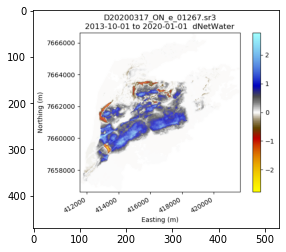

Image Distance [0.2536246  0.         0.21971745]
NAMES ['c:\\users\\prakalp.somawanshi\\local store\\qrm\\projects\\imgcmp\\data\\img2.png', 'c:\\users\\prakalp.somawanshi\\local store\\qrm\\projects\\imgcmp\\data\\img3.png', 'c:\\users\\prakalp.somawanshi\\local store\\qrm\\projects\\imgcmp\\data\\img1.png']
Result images ========================================
0
Match 1.0


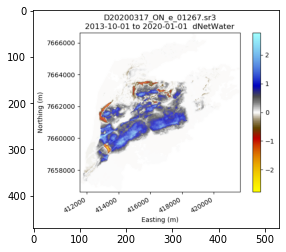

1
Match 0.78028255151899


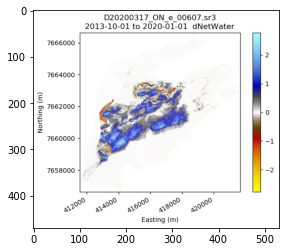

2
Match 0.7463753994976177


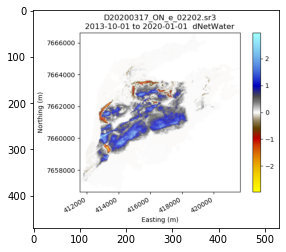

SAMPLES C:\Users\Prakalp.Somawanshi\Local Store\QRM\Projects\ImgCmp\data\img3.png
Query image ==========================================


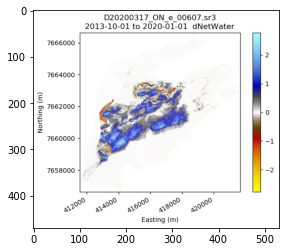

Image Distance [0.26374196 0.21971745 0.        ]
NAMES ['c:\\users\\prakalp.somawanshi\\local store\\qrm\\projects\\imgcmp\\data\\img3.png', 'c:\\users\\prakalp.somawanshi\\local store\\qrm\\projects\\imgcmp\\data\\img2.png', 'c:\\users\\prakalp.somawanshi\\local store\\qrm\\projects\\imgcmp\\data\\img1.png']
Result images ========================================
0
Match 1.0


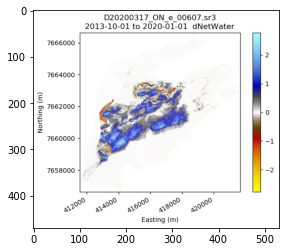

1
Match 0.78028255151899


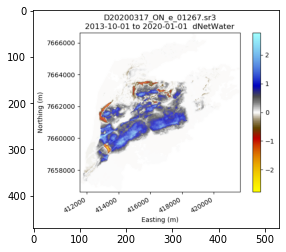

2
Match 0.7362580385432008


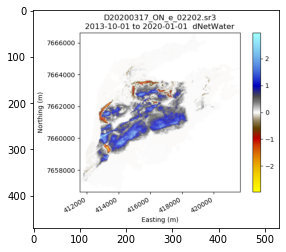

SAMPLES C:\Users\Prakalp.Somawanshi\Local Store\QRM\Projects\ImgCmp\data\img1.png
Query image ==========================================


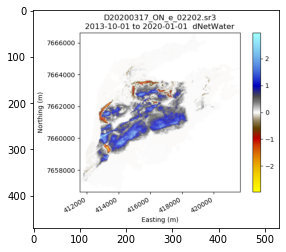

Image Distance [2.22044605e-16 2.53624601e-01 2.63741961e-01]
NAMES ['c:\\users\\prakalp.somawanshi\\local store\\qrm\\projects\\imgcmp\\data\\img1.png', 'c:\\users\\prakalp.somawanshi\\local store\\qrm\\projects\\imgcmp\\data\\img2.png', 'c:\\users\\prakalp.somawanshi\\local store\\qrm\\projects\\imgcmp\\data\\img3.png']
Result images ========================================
0
Match 0.9999999999999998


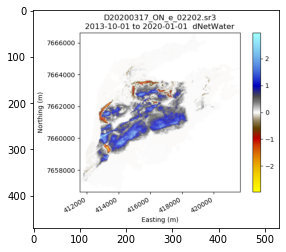

1
Match 0.7463753994976177


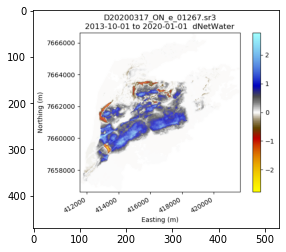

2
Match 0.7362580385432008


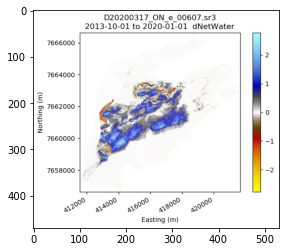

In [4]:
def show_img(path):
    img = imageio.imread(path)
#     , mode="RGB")
    plt.imshow(img)
    plt.show()
    
def run():
    images_path = r'C:\Users\Prakalp.Somawanshi\Local Store\QRM\Projects\ImgCmp\data'
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    print("FILES:",files)
    # getting 3 random images 
    sample = random.sample(files, 3)
    
    batch_extractor(images_path)

    ma = Matcher('features.pck')
    
    for s in sample:
        print("SAMPLES", s)
        print('Query image ==========================================')
        show_img(s)
        names, match = ma.match(s, topn=3)
        print("NAMES",names)
        print ('Result images ========================================')
        for i in range(3):
            print(i)
            # we got cosine distance, less cosine distance between vectors
            # more they similar, thus we subtruct it from 1 to get match value
            print('Match %s' % (1-match[i]))
            show_img(os.path.join(images_path, names[i]))

run()